In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import random
from sklearn.naive_bayes import CategoricalNB
from sklearn import preprocessing
from sklearn.manifold import TSNE
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.metrics import accuracy_score
from time import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#first 5 entries in training dataset
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#Rows and column in train and test datasets
train.shape,test.shape

((7613, 5), (3263, 4))

In [5]:
#checking null values in training and testing datasets 
train_null = train.isnull().sum()
test_null = test.isnull().sum()
train_null,test_null

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 id             0
 keyword       26
 location    1105
 text           0
 dtype: int64)

In [6]:
#dropping duplicates 
#As we see nearly 100 duplicates got deleted
train=train.drop_duplicates(subset=['text', 'target'], keep='first')
train.shape

(7521, 5)

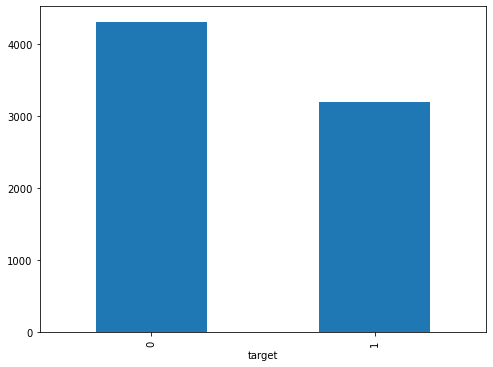

In [7]:
#now we check the target distribution
fig = plt.figure(figsize=(8,6))
train.groupby('target').id.count().plot.bar(ylim=0)
plt.show()

In [8]:
# Numbers of word for each sapmle in train & test data

train['char_len'] = train.text.str.len()
test['char_len'] = test.text.str.len()

word_tokens_train = [len(word_tokenize(trains)) for trains in train.text]
word_tokens_test = [len(word_tokenize(tests)) for tests in test.text]

train['word_len'] = word_tokens_train
test['word_len'] = word_tokens_test

sent_tokens_train = [len(sent_tokenize(trains)) for trains in train.text]
sent_tokens_test = [len(sent_tokenize(tests)) for tests in test.text]

train['sent_len'] = sent_tokens_train
test['sent_len'] = sent_tokens_test

In [9]:
train.head()

,id,keyword,location,text,target,char_len,word_len,sent_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,14,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,8,2
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,24,2
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,9,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,18,1


In [10]:
#Hist plot

def plot_char_count(df, data_name):
  sns.distplot(df['char_len'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

def plot_word_count(df, data_name):
  sns.distplot(df['word_len'].values)
  plt.title(f'Sequence word count: {data_name}')
  plt.grid(True)

def plot_sent_count(df, data_name):
  sns.distplot(df['sent_len'].values)
  plt.title(f'Sequence sentence count: {data_name}')
  plt.grid(True)

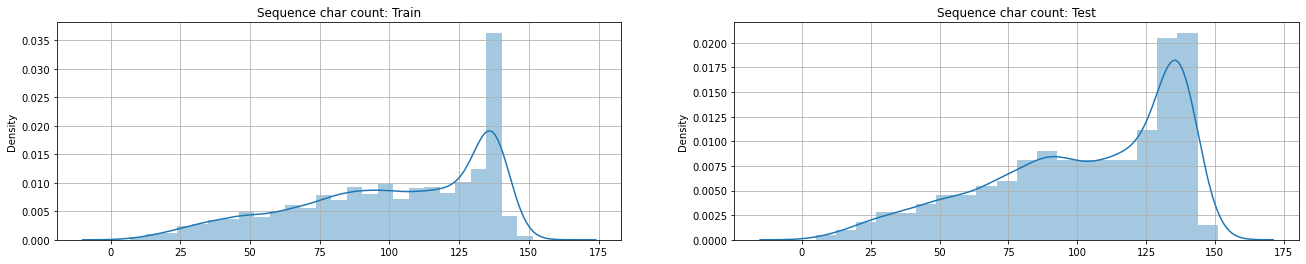

In [11]:
plt.subplot(1, 2, 1)
plot_char_count(train, 'Train')

plt.subplot(1, 2, 2)
plot_char_count(test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

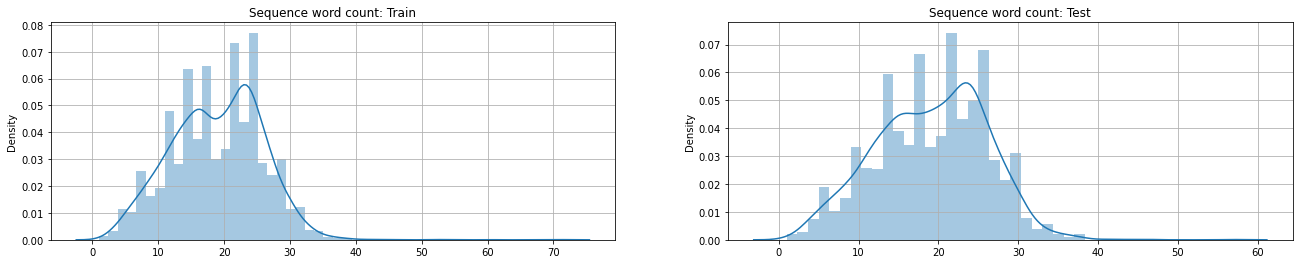

In [12]:
plt.subplot(1, 2, 1)
plot_word_count(train, 'Train')

plt.subplot(1, 2, 2)
plot_word_count(test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

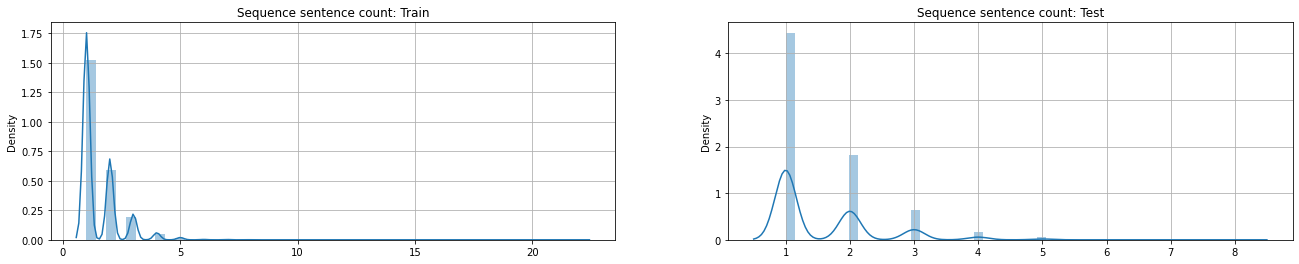

In [13]:
plt.subplot(1, 2, 1)
plot_sent_count(train, 'Train')

plt.subplot(1, 2, 2)
plot_sent_count(test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [14]:
# collecting all words in single list
list_= []
for i in train.text:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()
vocabulary= set(allWords)

In [15]:
len(vocabulary)

31480

In [16]:
def create_corpus(df,target):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<AxesSubplot:>

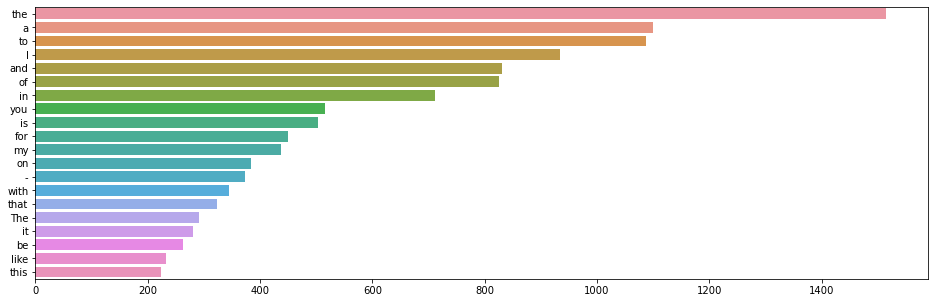

In [17]:
import collections
allWords=create_corpus(train,target=0)
vocabulary= set(allWords)
vocabulary_list= list(vocabulary)

plt.figure(figsize=(16,5))
counter=collections.Counter(allWords)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
  x.append(word)
  y.append(count)
sns.barplot(x=y,y=x)

<AxesSubplot:>

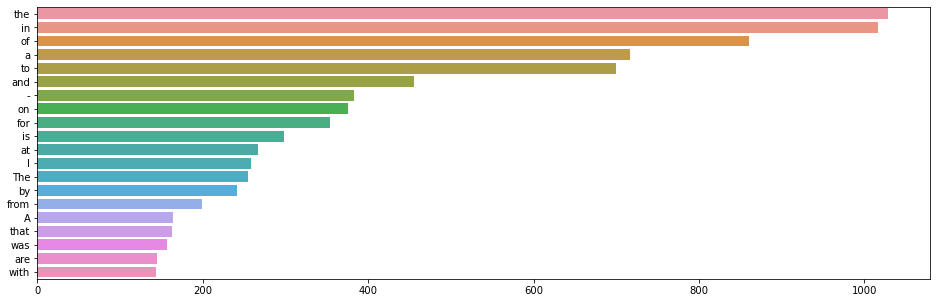

In [18]:
allWords=create_corpus(train,target=1)
vocabulary= set(allWords)
vocabulary_list= list(vocabulary)

plt.figure(figsize=(16,5))
counter=collections.Counter(allWords)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
  x.append(word)
  y.append(count)
sns.barplot(x=y,y=x)

In [19]:
#Data Cleaning
#Remove Puntuation
pstem = PorterStemmer()
def clean_text(text):
    text = text.lower()
    text = re.sub('[0-9]','',text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r" amp ", " and ", text)
    text  = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens=[pstem.stem(word) for word in tokens]
    tokens=[lemmatizer.lemmatize(word) for word in tokens]
    #tokens=[word for word in tokens if word not in stopwords.words('english')]
    text = ' '.join(tokens)
    return text

In [20]:
EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
URLPATTERN        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"

In [21]:
def preprocess_text(text):
    text = re.sub(URLPATTERN,' URL',text)
    ### Replacing EMOJI
    for emoji in EMOJIS.keys():
        text = text.replace(emoji,EMOJIS[emoji])  
    return text

In [22]:
train.head()

,id,keyword,location,text,target,char_len,word_len,sent_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,14,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,8,2
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,24,2
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,9,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,18,1


In [23]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
train["clean"]=train["text"].apply(clean_text)
test["clean"]=test["text"].apply(clean_text)

In [24]:
train["clean"]=train["clean"].apply(preprocess_text)
test["clean"]=test["clean"].apply(preprocess_text)

In [25]:
list_= []
for i in train.clean:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()
vocabulary= set(allWords)
len(vocabulary)

20145

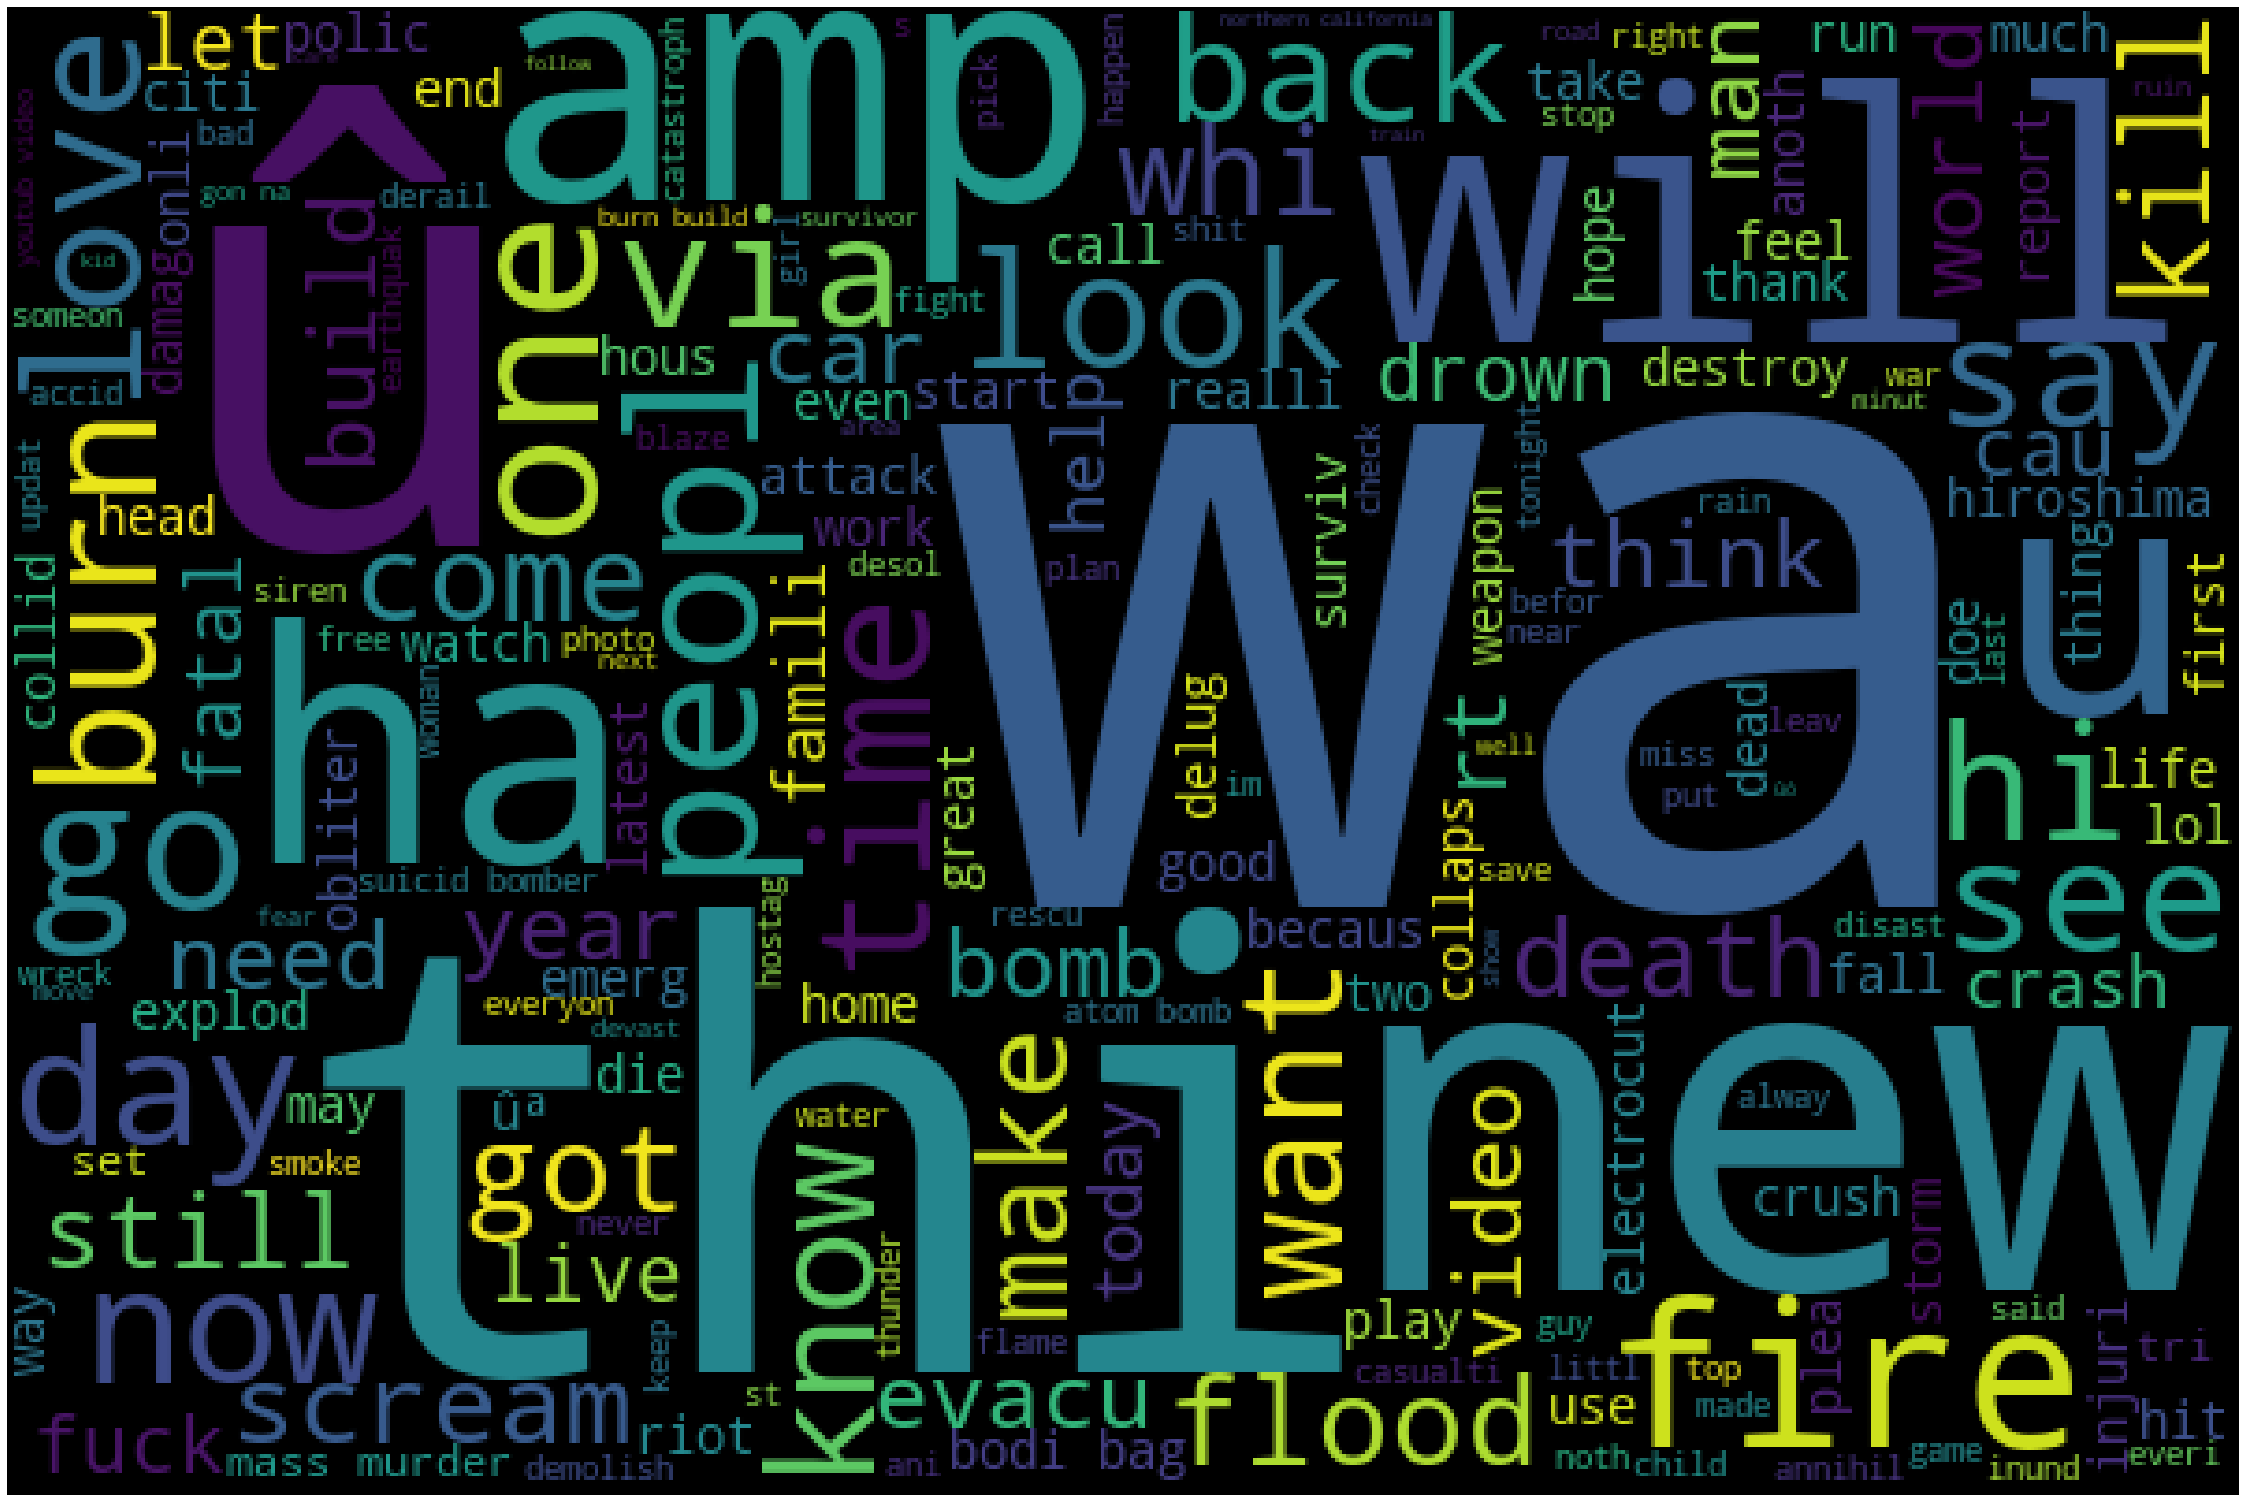

In [26]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
# Import package
from wordcloud import WordCloud
# Generate word cloud
wordcloud = WordCloud(width = 600, height = 400).generate(" ".join(train['clean']))
plot_cloud(wordcloud)

In [27]:
train.drop(['keyword','location','text','id'],1,inplace=True)
test.drop(['keyword','location','text'],1,inplace=True)

In [28]:
tfidf = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
train_tfidf = tfidf.fit_transform(train['clean'])
test_tfidf = tfidf.transform(test['clean'])

In [29]:
mnb = MultinomialNB(alpha = 2.0)
scores_tfidf = model_selection.cross_val_score(mnb,train_tfidf,train['target'],cv = 10,scoring = 'f1')
print("score of tfidf:",scores_tfidf)

score of tfidf: [0.61167002 0.49471459 0.57954545 0.50570342 0.61538462 0.55805243
 0.54989817 0.50638298 0.71143376 0.72347826]


In [30]:
lg = LogisticRegression(C = 1.0)
scores_tfidf = model_selection.cross_val_score(lg, train_tfidf, train["target"], cv = 5, scoring = "f1")
print("score of tfidf:",scores_tfidf)

score of tfidf: [0.60636183 0.57490637 0.63874346 0.55589744 0.71866784]


In [31]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, random_state=48, shuffle=True)
accuracy=[]
n=1
y=train['target']

In [32]:
sub = pd.read_csv('sample_submission.csv')

In [33]:
for trn_idx, test_idx in skf.split(train_tfidf, y):
  start_time = time()
  X_tr,X_val=train_tfidf[trn_idx],train_tfidf[test_idx]
  y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
  model= LogisticRegression(max_iter=1000,C=3)
  #model=MultinomialNB(alpha=0.5)
  #model=svm.SVC(max_iter=1000)
  model.fit(X_tr,y_tr)
  s = model.predict(X_val)
  sub[str(n)]= model.predict(test_tfidf) 
  
  accuracy.append(accuracy_score(y_val, s))
  print((time() - start_time)/60,accuracy[n-1])
  n+=1

0.002253123124440511 0.8043593833067517
0.0018230438232421874 0.8069148936170213
0.001487433910369873 0.7973404255319149
0.0024012049039204915 0.7984042553191489


In [34]:
np.mean(accuracy)*100

80.17547394437092

In [35]:
sub

,id,target,1,2,3,4
0,0,0,1,1,1,1
1,2,0,0,1,1,1
2,3,0,1,1,1,1
3,9,0,1,1,1,1
4,11,0,1,1,1,1
...,...,...,...,...,...,...
3258,10861,0,1,1,1,1
3259,10865,0,0,1,1,1
3260,10868,0,1,1,1,1
3261,10874,0,1,1,1,1


In [36]:
df=sub[['1','2','3','4']].mode(axis=1)   # select the most frequent predicted class by our model
sub['target']=df[0]    
sub=sub[['id','target']]
sub['target']=sub['target'].apply(lambda x : int(x))

In [37]:
sub.to_csv('submission.csv',index=False)